In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor

from environment.env import Simulatio4RecSys

from environment.citations.citation_loader import CitationsLoader
from environment.users.citation_users_loader import CitationUsersLoader

from environment.items_selection import GreedySelector
from environment.reward_perturbator import NoPerturbator
from environment.reward_shaping import IdentityRewardShaping
from environment.citations.citations_retrieval import CitationsRetrieval
from environment.LLM.dummy_llm import DummyLLM
from environment.LLM.rater import DummyLLMRater
from environment.flat_obs_wrapper import FlatObsWrapper

# Loaders
items_loader = CitationsLoader("../environment/citations/datasets/cleaned-scientometrics-and-bibliometrics-research.csv")
users_loader = CitationUsersLoader("../environment/users/datasets/citation_users.json")

# Components
items_selector = GreedySelector()
reward_perturbator = NoPerturbator()
reward_shaping = IdentityRewardShaping()
llm_rater = DummyLLMRater(DummyLLM())

# Environment
raw_env = Simulatio4RecSys(
    render_mode="human",
    items_loader=items_loader,
    users_loader=users_loader,
    items_selector=items_selector,
    reward_perturbator=reward_perturbator,
    items_retrieval=CitationsRetrieval(),
    reward_shaping=reward_shaping,
    llm_rater=llm_rater
)

env = FlatObsWrapper(raw_env)
env = Monitor(env)



In [5]:
obs = env.reset()[0]
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)
print("Step ran. Reward:", reward)

Step ran. Reward: 6.5


Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 30.2     |
|    ep_rew_mean        | 196      |
| time/                 |          |
|    fps                | 208      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -10.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 203      |
|    value_loss         | 430      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 34.7     |
|    ep_rew_mean        | 226      |
| time/                 |          |
|    fps                | 198      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps   

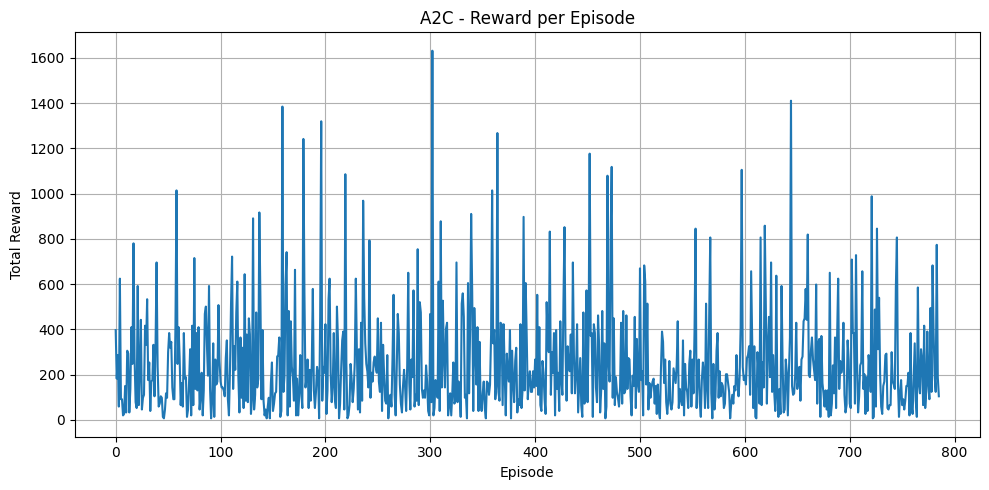

In [17]:
# Train
model = A2C("MultiInputPolicy", env, verbose=2, device='cpu')
model.learn(total_timesteps=20000)
# model.save("models/a2c_citation_recommender")

# Plot rewards
rewards = env.get_episode_rewards()
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title("A2C - Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from stable_baselines3 import DQN

model = DQN(
    policy="MultiInputPolicy",
    env=env,
    verbose=1,
    learning_rate=1e-4,        # Feel free to tune
    buffer_size=10000,         # Replay buffer size
    learning_starts=1000,      # Delay learning until some experiences are collected
    batch_size=64,
    train_freq=1,
    target_update_interval=500,
    device="cpu",              # Or "cuda" if available
)

model.learn(total_timesteps=50000)
# model.save("models/dqn_citation_recommender")


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.8     |
|    ep_rew_mean      | 265      |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 591      |
|    time_elapsed     | 0        |
|    total_timesteps  | 163      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 212      |
|    exploration_rate | 0.95     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 645      |
|    time_elapsed     | 0        |
|    total_timesteps  | 261      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 213      |
|    exploration_rate | 0.925    |
| t

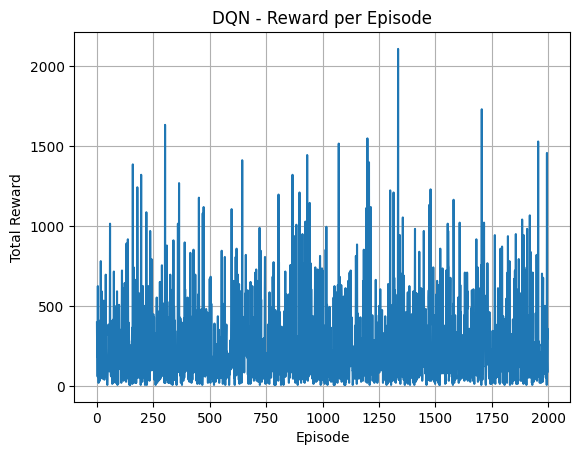

In [20]:
rewards = env.get_episode_rewards()
plt.plot(rewards)
plt.title("DQN - Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


In [18]:
# --- Reset until target user ---
target_user_name = "CitationUser1"

while True:
    obs, _ = env.reset()
    user = env.unwrapped._user
    if user.name == target_user_name:
        break

# --- Predict top recommendation ---
action, _ = model.predict(obs, deterministic=True)
action = int(action)  # ✅ ensure it's an int
item_id = env.unwrapped.action_to_item[action]
citation = env.unwrapped.items_loader.load_items_from_ids([item_id])[0]

# --- Print output ---
print("="*50)
print(f"👤 USER PROFILE")
print(f"   Name    : {user.name}")
print(f"   Gender  : {user.gender}")
print(f"   Age     : {user.age}")
print(f"   Prefs   : {user.description}")
print()

print(f"📚 RECOMMENDED PAPER")
print(f"   Title   : {citation.title}")
print(f"   Year    : {citation.year}")
print(f"   Topics  : {', '.join(citation.topics)}")
print(f"   Citations: {citation.cited_by_count}")
print(f"   Norm. Year     : {citation.norm_year:.2f}")
print(f"   Norm. Citations: {citation.norm_cite:.2f}")
print("="*50)


👤 USER PROFILE
   Name    : CitationUser1
   Gender  : M
   Age     : 30
   Prefs   : Interested in: Science and Science Education, Intellectual Capital and Performance Analysis, Innovation Policy and R&D. Prefers novelty: 0.5, reputability bias: 0.65

📚 RECOMMENDED PAPER
   Title   : The Participation and Motivations of Grant Peer Reviewers: A Comprehensive Survey
   Year    : 2019
   Topics  : scientometrics and bibliometrics research, Health and Medical Research Impacts, Meta-analysis and systematic reviews
   Citations: 13
   Norm. Year     : 0.99
   Norm. Citations: 0.25
